In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import xgboost as xgb
from utility import *

In [2]:
base = "/Users/claxl/Documents/GitHub/MLProject/Data Exploration/EDA/clearData/"

In [3]:
df_train_est_A, df_train_obs_A, df_test_A = readData(base,1)
df_train_est_B, df_train_obs_B, df_test_B = readData(base,2)
df_train_est_C, df_train_obs_C, df_test_C = readData(base,3)

In [4]:
df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)

df_train_est_B.set_index('date_forecast', inplace=True)
df_train_obs_B.set_index('date_forecast', inplace=True)
df_test_B.set_index('date_forecast', inplace=True)

df_train_est_C.set_index('date_forecast', inplace=True)
df_train_obs_C.set_index('date_forecast', inplace=True)
df_test_C.set_index('date_forecast', inplace=True)

In [5]:
df_train = get_df_train(df_train_est_A,df_train_obs_A)
df_test = df_test_A

In [6]:
features_name = [c for c in df_train.columns if c != 'pv_measurement']
target = 'pv_measurement'
X = df_train[features_name]
y = df_train[target]
X_test = df_test[features_name]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False)

In [8]:
# Calcola il primo e terzo quartile per ciascuna colonna
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)

    # Calcola l'intervallo interquartile (IQR) per ciascuna colonna
IQR = Q3 - Q1

    # Definisci i limiti per identificare gli outlier per ciascuna colonna
limite_inferiore = Q1 - 3 * IQR
limite_superiore = Q3 + 3 * IQR

    # Sostituisci gli outlier con i valori più estremi tra i non-outlier per ciascuna colonna
for colonna in X_train.columns:
    X_train[colonna] = X_train[colonna].apply(lambda x: limite_inferiore[colonna] if x < limite_inferiore[colonna] else (limite_superiore[colonna] if x > limite_superiore[colonna] else x))

In [9]:
# Calcola il primo e terzo quartile per ciascuna colonna
Q1 = X_test.quantile(0.25)
Q3 = X_test.quantile(0.75)

# Calcola l'intervallo interquartile (IQR) per ciascuna colonna
IQR = Q3 - Q1

# Definisci i limiti per identificare gli outlier per ciascuna colonna
limite_inferiore = Q1 - 3 * IQR
limite_superiore = Q3 + 3 * IQR

# Sostituisci gli outlier con i valori più estremi tra i non-outlier per ciascuna colonna
for colonna in X_test.columns:
    X_test[colonna] = X_test[colonna].apply(lambda x: limite_inferiore[colonna] if x < limite_inferiore[colonna] else (limite_superiore[colonna] if x > limite_superiore[colonna] else x))

### 1. Correlation between target and features

In [10]:
target = 'pv_measurement'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


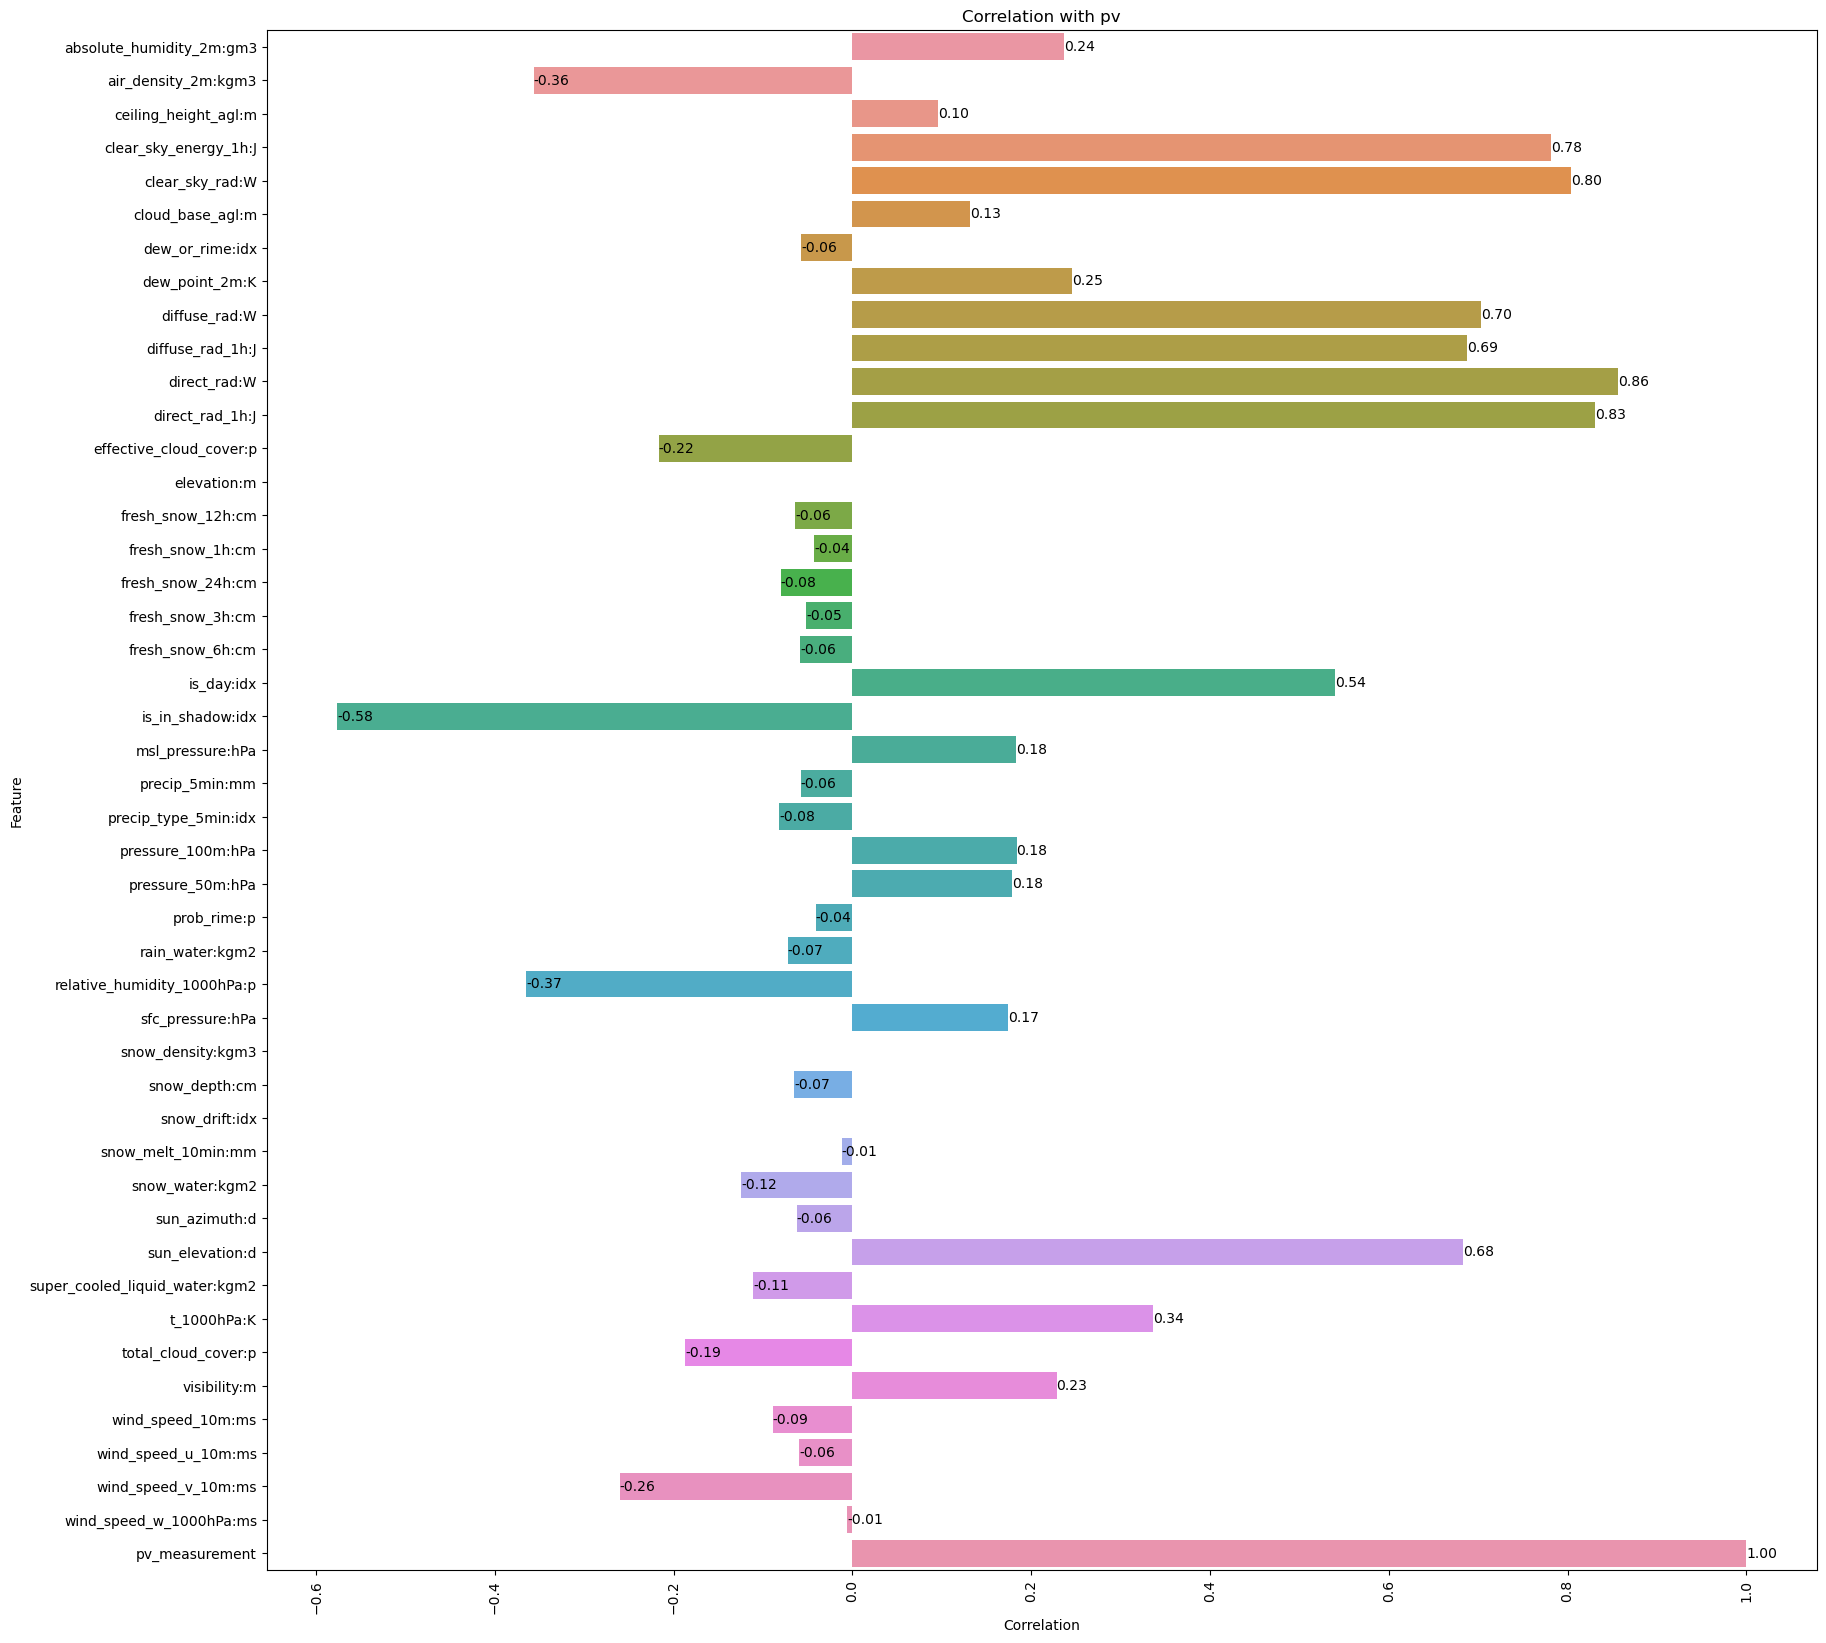

In [11]:
# Crea un dataframe di esempio con numeri nei nomi delle colonne
df = pd.concat([df_train_obs_A, df_train_est_A], ignore_index=True)
# Calcola la matrice di correlazione
correlation_matrix = df.corrwith(df[target])
plt.figure(figsize=(20, 20))
ax = sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index, orient='h')
plt.title('Correlation with pv')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.xticks(rotation=90)
for i, v in enumerate(correlation_matrix.values):
    ax.text(v, i, f'{v:.2f}', ha='left', va='center')
plt.show()

### 2. Correlation between features

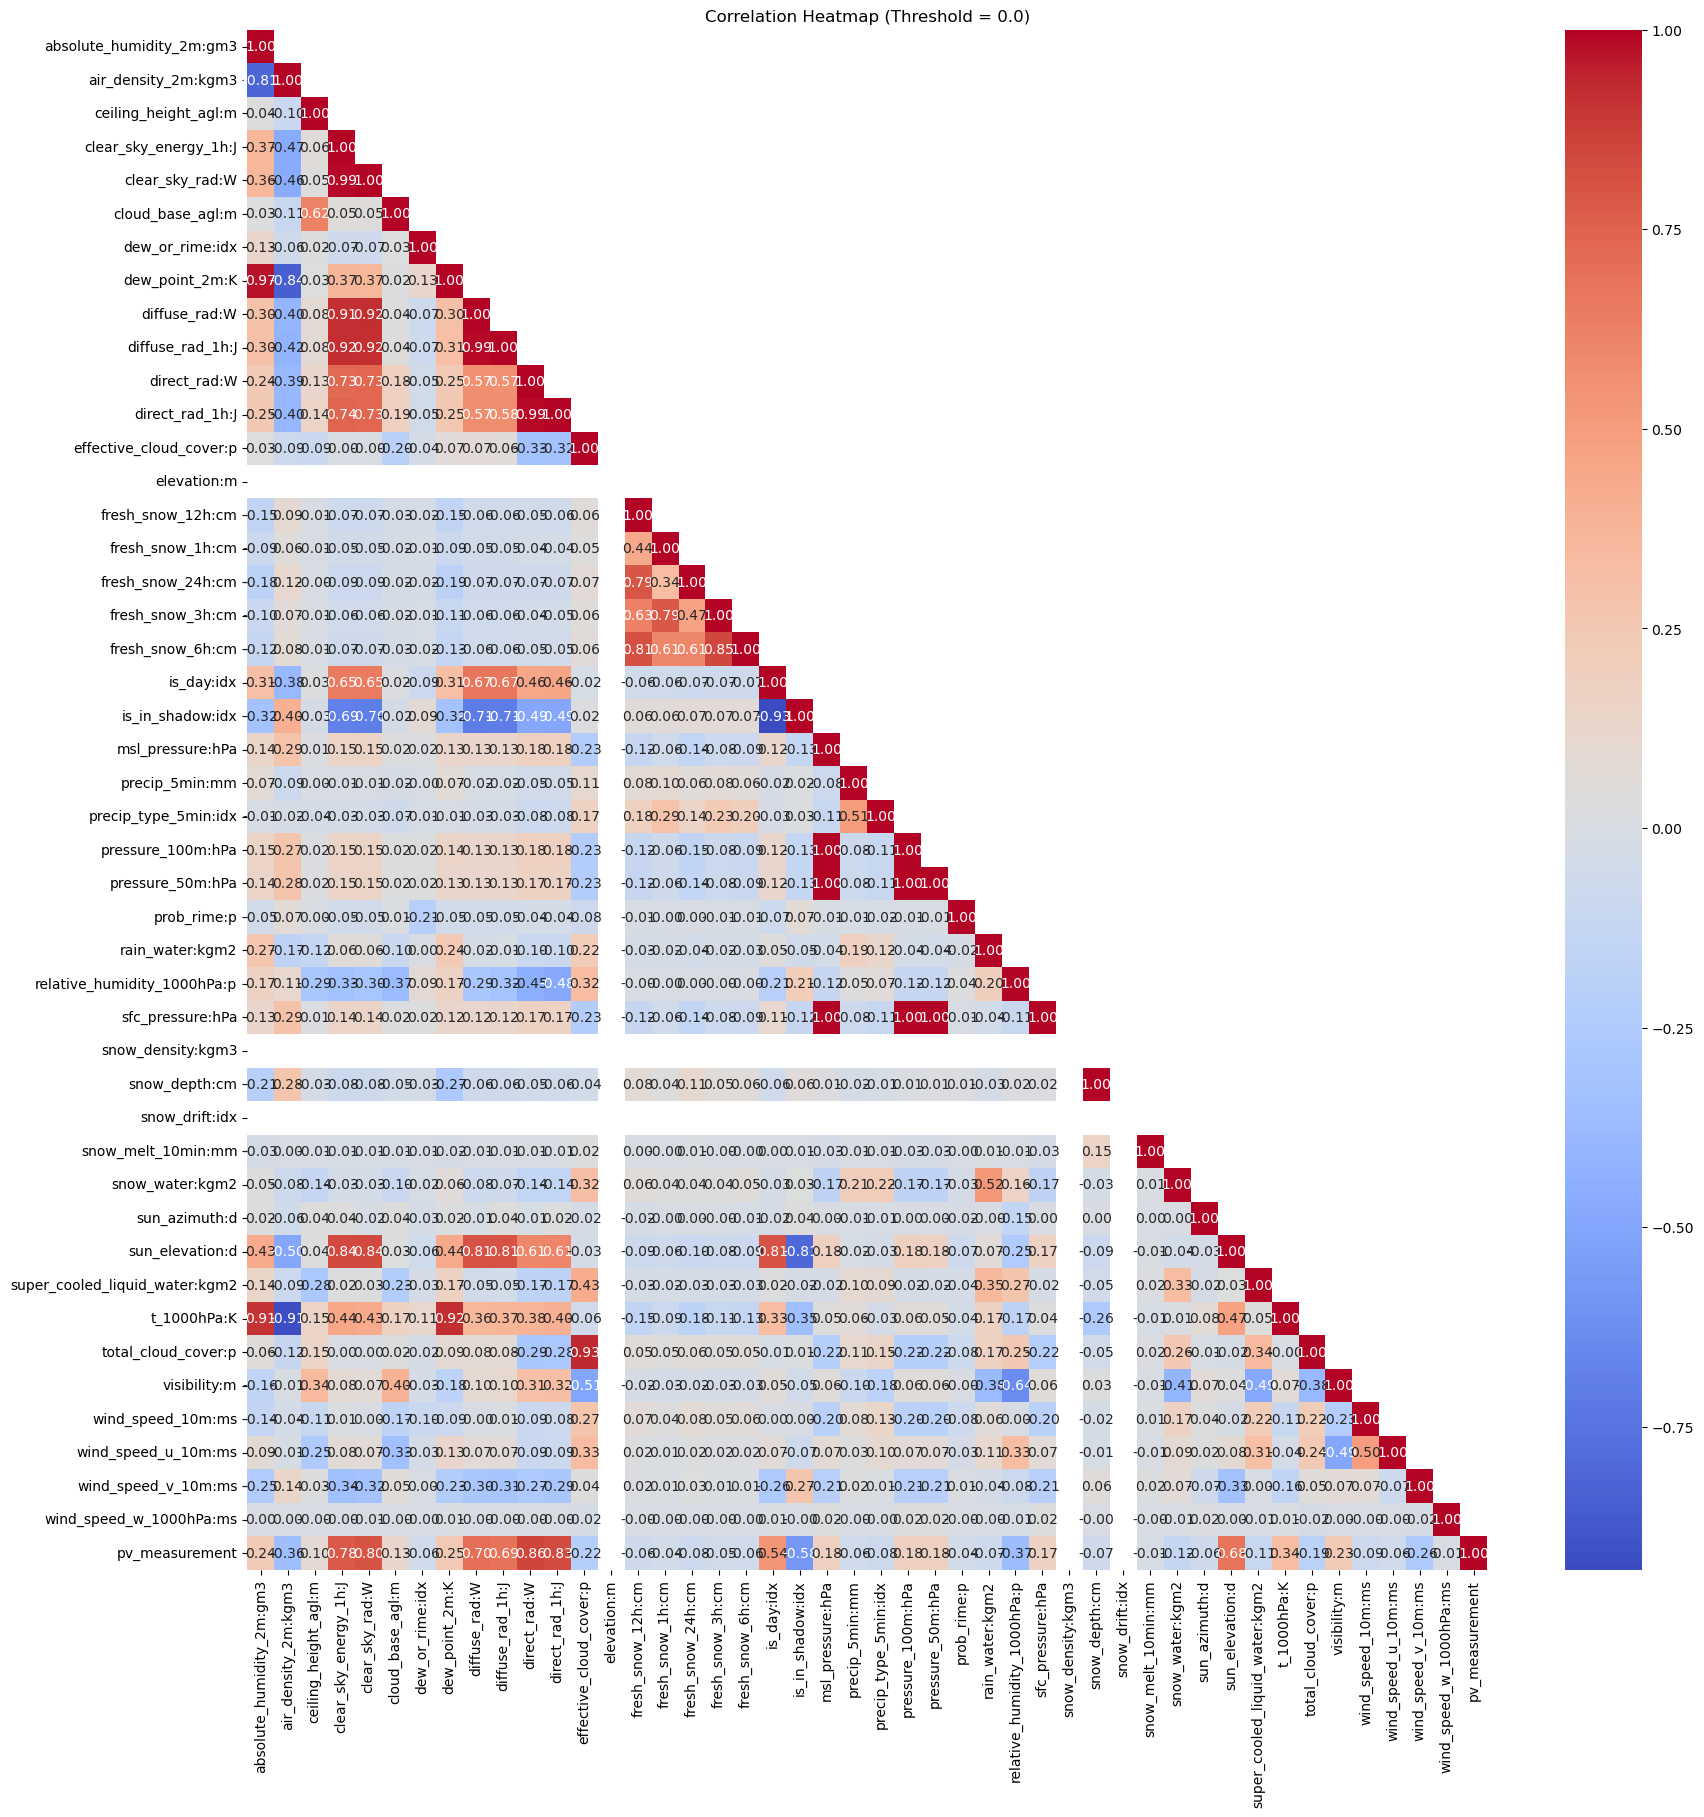

In [13]:
df = pd.concat([df_train_obs_A, df_train_est_A], ignore_index=True)

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Definisci la soglia
threshold = 0.0

# Trova le colonne da mantenere
columns_to_keep = correlation_matrix.columns[(correlation_matrix >= threshold).sum() >=0]

# Seleziona solo le colonne che soddisfano il criterio
filtered_corr_matrix = correlation_matrix.loc[columns_to_keep, columns_to_keep]
mask_upper = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Crea una heatmap della matrice di correlazione filtrata
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask_upper)
plt.title(f'Correlation Heatmap (Threshold = {threshold})')
plt.show()


Train feature after a filter based on a threshold

In [14]:
df = X_train
to_keep_columns = correlation_matrix.drop(columns=['pv_measurement'])
print(to_keep_columns.columns)
df = df[to_keep_columns.columns].to_numpy()

df.shape

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

(30654, 45)

### 3. PCA & Pipeline

In [25]:
pipeline = Pipeline(steps=[('Scaler', Normalizer()), 
                                 ('PCA', PCA(n_components=40)), 
                                 ('Forest', RandomForestRegressor(n_estimators=100, max_depth=5))])

In [26]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
mean_absolute_error(y_test, y_pred)

290.46427635718413

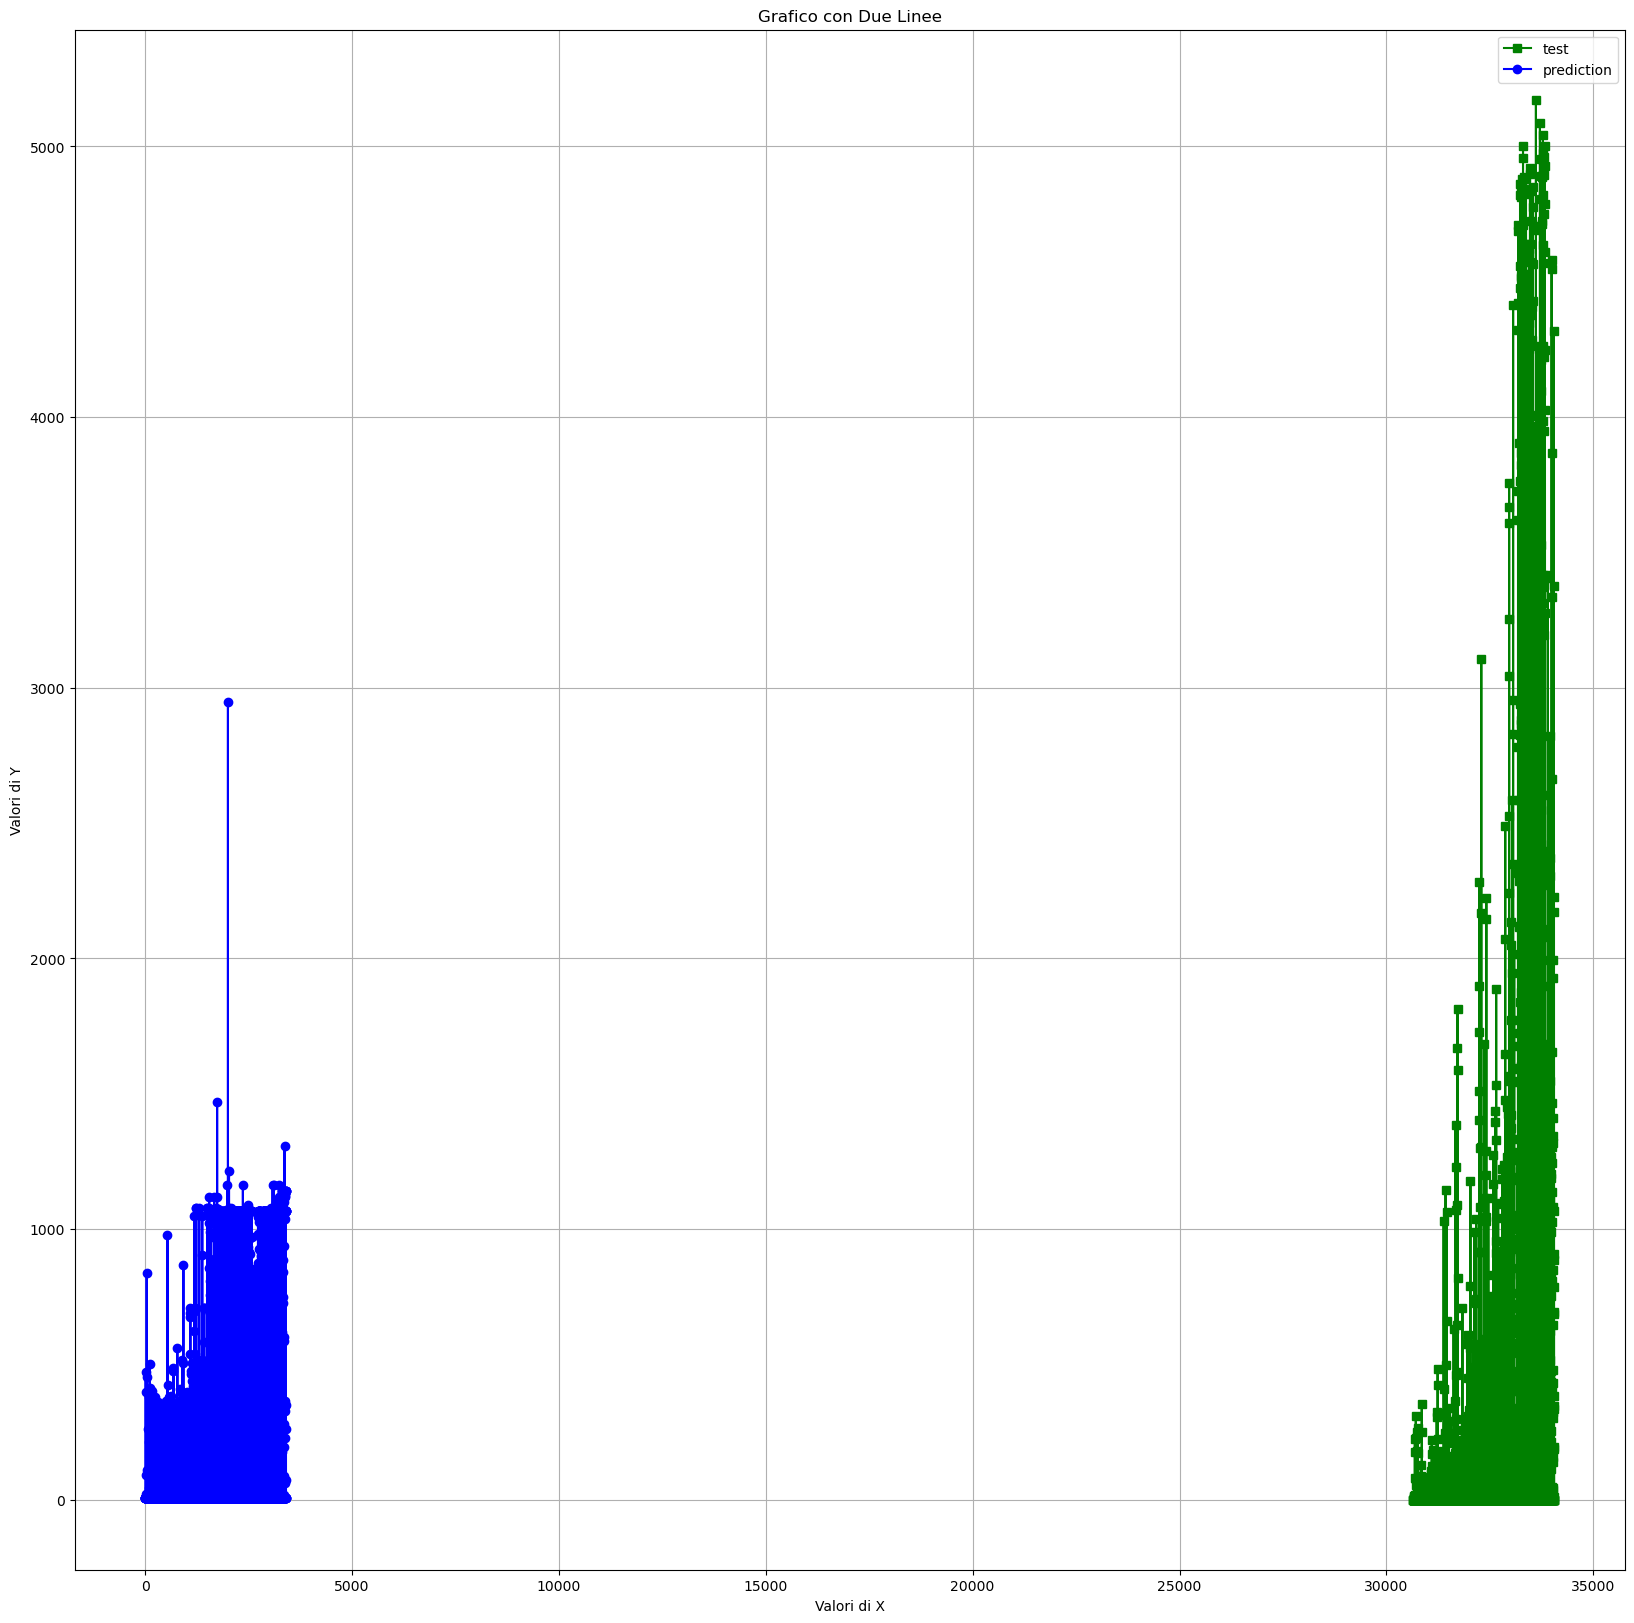

In [27]:
plt.figure(figsize=(20, 20))
plt.plot(y_test, label='test', color='g', marker='s')
plt.plot(y_pred, label='prediction', color='b', marker='o')


# Aggiungi titoli ed etichette
plt.title('Grafico con Due Linee')
plt.xlabel('Valori di X')
plt.ylabel('Valori di Y')

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()